In [1]:
import tensorflow as tf
import os
import json
import pandas as pd
import re
import numpy as np
import time
import matplotlib.pyplot as plt
import collections
import random
import requests
import json
from math import sqrt
from PIL import Image
from tqdm.auto import tqdm

c:\Users\ASUS\Desktop\COCO\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open(r'F:\COCO\annotations_trainval2014\annotations\captions_train2014.json', 'r') as f:
    data = json.load(f)
    data = data['annotations']


In [3]:
data

[{'image_id': 318556,
  'id': 48,
  'caption': 'A very clean and well decorated empty bathroom'},
 {'image_id': 116100,
  'id': 67,
  'caption': 'A panoramic view of a kitchen and all of its appliances.'},
 {'image_id': 318556,
  'id': 126,
  'caption': 'A blue and white bathroom with butterfly themed wall tiles.'},
 {'image_id': 116100,
  'id': 148,
  'caption': 'A panoramic photo of a kitchen and dining room'},
 {'image_id': 379340,
  'id': 173,
  'caption': 'A graffiti-ed stop sign across the street from a red car '},
 {'image_id': 379340,
  'id': 188,
  'caption': 'A vandalized stop sign and a red beetle on the road'},
 {'image_id': 318556,
  'id': 219,
  'caption': 'A bathroom with a border of butterflies and blue paint on the walls above it.'},
 {'image_id': 318556,
  'id': 255,
  'caption': 'An angled view of a beautifully decorated bathroom.'},
 {'image_id': 134754,
  'id': 272,
  'caption': 'The two people are walking down the beach.'},
 {'image_id': 538480,
  'id': 288,
  'ca

In [4]:
img_cap_pairs = []
for sample in data:
    img_name = '%012d.jpg' % sample['image_id']
    img_cap_pairs.append([img_name, sample['caption']])


In [5]:
img_cap_pairs

[['000000318556.jpg', 'A very clean and well decorated empty bathroom'],
 ['000000116100.jpg',
  'A panoramic view of a kitchen and all of its appliances.'],
 ['000000318556.jpg',
  'A blue and white bathroom with butterfly themed wall tiles.'],
 ['000000116100.jpg', 'A panoramic photo of a kitchen and dining room'],
 ['000000379340.jpg',
  'A graffiti-ed stop sign across the street from a red car '],
 ['000000379340.jpg', 'A vandalized stop sign and a red beetle on the road'],
 ['000000318556.jpg',
  'A bathroom with a border of butterflies and blue paint on the walls above it.'],
 ['000000318556.jpg', 'An angled view of a beautifully decorated bathroom.'],
 ['000000134754.jpg', 'The two people are walking down the beach.'],
 ['000000538480.jpg', 'A sink and a toilet inside a small bathroom.'],
 ['000000476220.jpg', 'An empty kitchen with white and black appliances.'],
 ['000000299675.jpg',
  'A white square kitchen with tile floor that needs repairs '],
 ['000000032275.jpg', 'The van

In [6]:
captions = pd.DataFrame(img_cap_pairs, columns=['image', 'caption'])
captions['image'] = captions['image'].apply(
    lambda x: rf'F:\COCO\train2014\train2014\COCO_train2014_{x}'
)

In [7]:
captions

,image,caption
0,F:\COCO\train2014\train2014\COCO_train2014_000...,A very clean and well decorated empty bathroom
1,F:\COCO\train2014\train2014\COCO_train2014_000...,A panoramic view of a kitchen and all of its a...
2,F:\COCO\train2014\train2014\COCO_train2014_000...,A blue and white bathroom with butterfly theme...
3,F:\COCO\train2014\train2014\COCO_train2014_000...,A panoramic photo of a kitchen and dining room
4,F:\COCO\train2014\train2014\COCO_train2014_000...,A graffiti-ed stop sign across the street from...
...,...,...
414108,F:\COCO\train2014\train2014\COCO_train2014_000...,a slice of bread is covered with a sour cream ...
414109,F:\COCO\train2014\train2014\COCO_train2014_000...,A long plate hold some fries with some sliders...
414110,F:\COCO\train2014\train2014\COCO_train2014_000...,Two women sit and pose with stuffed animals.
414111,F:\COCO\train2014\train2014\COCO_train2014_000...,White Plate with a lot of guacamole and an ext...


In [8]:
captions = captions.sample(70000)
captions = captions.reset_index(drop=True)
captions.head()

,image,caption
0,F:\COCO\train2014\train2014\COCO_train2014_000...,A small bathroom has a toilet with stripes on it.
1,F:\COCO\train2014\train2014\COCO_train2014_000...,a man on a skateboard riding a pipe
2,F:\COCO\train2014\train2014\COCO_train2014_000...,A banana and two lemons sitting on a table.
3,F:\COCO\train2014\train2014\COCO_train2014_000...,this is several zebras in the grass running
4,F:\COCO\train2014\train2014\COCO_train2014_000...,A man standing in the middle of a room and hol...


In [9]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip()
    text = '[start] ' + text + ' [end]'
    return text

In [10]:
captions['caption'] = captions['caption'].apply(preprocess)
captions.head()


,image,caption
0,F:\COCO\train2014\train2014\COCO_train2014_000...,[start] a small bathroom has a toilet with str...
1,F:\COCO\train2014\train2014\COCO_train2014_000...,[start] a man on a skateboard riding a pipe [end]
2,F:\COCO\train2014\train2014\COCO_train2014_000...,[start] a banana and two lemons sitting on a t...
3,F:\COCO\train2014\train2014\COCO_train2014_000...,[start] this is several zebras in the grass ru...
4,F:\COCO\train2014\train2014\COCO_train2014_000...,[start] a man standing in the middle of a room...


[start] a man and woman riding a bike in the street [end]



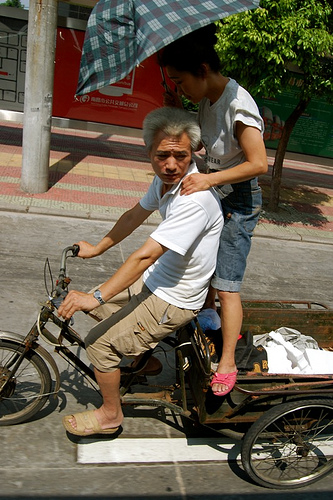

In [11]:
random_row = captions.sample(1).iloc[0]
print(random_row.caption)
print()
im = Image.open(random_row.image)
im

In [12]:
MAX_LENGTH = 40
VOCABULARY_SIZE = 15000
BATCH_SIZE = 64
BUFFER_SIZE = 1000
EMBEDDING_DIM = 512
UNITS = 512
EPOCHS = 5


In [13]:
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE,
    standardize=None,
    output_sequence_length=MAX_LENGTH)

tokenizer.adapt(captions['caption'])

In [14]:
tokenizer.vocabulary_size()

11773

In [15]:
import pickle

pickle.dump(tokenizer.get_vocabulary(), open('vocab_coco1.pkl', 'wb'))


In [16]:
word2idx = tf.keras.layers.StringLookup(
    mask_token = '',
    vocabulary=tokenizer.get_vocabulary()
)

idx2word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [17]:
img_to_cap_vector = collections.defaultdict(list)

for img, cap in zip(captions['image'], captions['caption']):
    img_to_cap_vector[img].append(cap)

In [18]:
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

In [19]:
slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = (img_keys[:slice_index], 
                                          img_keys[slice_index:])


In [20]:
train_imgs = []
train_captions = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    train_imgs.extend([imgt] * capt_len)
    train_captions.extend(img_to_cap_vector[imgt])

val_imgs = []
val_captions = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    val_imgs.extend([imgv] * capv_len)
    val_captions.extend(img_to_cap_vector[imgv])

In [21]:
train_imgs

['F:\\COCO\\train2014\\train2014\\COCO_train2014_000000277623.jpg',
 'F:\\COCO\\train2014\\train2014\\COCO_train2014_000000126470.jpg',
 'F:\\COCO\\train2014\\train2014\\COCO_train2014_000000279588.jpg',
 'F:\\COCO\\train2014\\train2014\\COCO_train2014_000000103865.jpg',
 'F:\\COCO\\train2014\\train2014\\COCO_train2014_000000103865.jpg',
 'F:\\COCO\\train2014\\train2014\\COCO_train2014_000000544109.jpg',
 'F:\\COCO\\train2014\\train2014\\COCO_train2014_000000471599.jpg',
 'F:\\COCO\\train2014\\train2014\\COCO_train2014_000000194108.jpg',
 'F:\\COCO\\train2014\\train2014\\COCO_train2014_000000111141.jpg',
 'F:\\COCO\\train2014\\train2014\\COCO_train2014_000000017590.jpg',
 'F:\\COCO\\train2014\\train2014\\COCO_train2014_000000017590.jpg',
 'F:\\COCO\\train2014\\train2014\\COCO_train2014_000000248979.jpg',
 'F:\\COCO\\train2014\\train2014\\COCO_train2014_000000180672.jpg',
 'F:\\COCO\\train2014\\train2014\\COCO_train2014_000000180672.jpg',
 'F:\\COCO\\train2014\\train2014\\COCO_train2014

In [22]:
train_captions

['[start] two dogs that are standing in the dirt [end]',
 '[start] a man flying through the air while riding a snowboard [end]',
 '[start] two men lounge on a wall in front of a house and a tree [end]',
 '[start] a couple of giraffe standing in front of a cage eating hay [end]',
 '[start] two giraffes eat hay hanging from a wire fence [end]',
 '[start] 2 women sitting on a floor in a ceramic house preparing dinner [end]',
 '[start] dogs lays on the beach in the shade of an umbrella [end]',
 '[start] a tall tower with a clock on a city street [end]',
 '[start] a cat with a puzzled look on its face in a bath tub [end]',
 '[start] a group of people standing next to each other [end]',
 '[start] people standing outside with their umbrellas on the ground [end]',
 '[start] the train is traveling on the rather elevated rail [end]',
 '[start] an orange and white cat sitting on top of a musical keyboard [end]',
 '[start] a cat sitting on an organ looking out a window [end]',
 '[start] little lea

In [23]:
len(train_imgs), len(train_captions), len(val_imgs), len(val_captions)


(56105, 56105, 13895, 13895)

In [24]:
def load_data(img_path, caption):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    caption = tokenizer(caption)
    return img, caption


In [25]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_imgs, train_captions))

train_dataset = train_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_imgs, val_captions))

val_dataset = val_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [26]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

In [27]:
for images, labels in train_dataset:
    print(images.shape)  # This will give the shape of your image batch (e.g., (batch_size, 299, 299, 3))
    print(labels.shape)  # This will give the shape of your label batch (e.g., (batch_size,))
    print(labels)        # This will print the label values
    break  # To only inspect the first batch

(64, 299, 299, 3)
(64, 40)
tf.Tensor(
[[  3   2  28 ...   0   0   0]
 [  3   2  29 ...   0   0   0]
 [  3 107 318 ...   0   0   0]
 ...
 [  3  16  80 ...   0   0   0]
 [  3   7 211 ...   0   0   0]
 [  3   2 118 ...   0   0   0]], shape=(64, 40), dtype=int64)


In [28]:
image_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomContrast(0.3),
    ]
)

In [29]:
def CNN_Encoder():
    inception_v3 = tf.keras.applications.InceptionV3(
        include_top=False,
        weights='imagenet'
    )

    output = inception_v3.output
    output = tf.keras.layers.Reshape( 
        (-1, output.shape[-1]))(output)

    cnn_model = tf.keras.models.Model(inception_v3.input, output)
    return cnn_model

In [30]:
class TransformerEncoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.layer_norm_1 = tf.keras.layers.LayerNormalization()
        self.layer_norm_2 = tf.keras.layers.LayerNormalization()
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense = tf.keras.layers.Dense(embed_dim, activation="relu")
    

    def call(self, x, training):
        x = self.layer_norm_1(x)
        x = self.dense(x)

        attn_output = self.attention(
            query=x,
            value=x,
            key=x,
            attention_mask=None,
            training=training
        )

        x = self.layer_norm_2(x + attn_output)
        return x

In [31]:
class Embeddings(tf.keras.layers.Layer):

    def __init__(self, vocab_size, embed_dim, max_len):
        super().__init__()
        self.token_embeddings = tf.keras.layers.Embedding(
            vocab_size, embed_dim)
        self.position_embeddings = tf.keras.layers.Embedding(
            max_len, embed_dim, input_shape=(None, max_len))
    

    def call(self, input_ids):
        length = tf.shape(input_ids)[-1]
        position_ids = tf.range(start=0, limit=length, delta=1)
        position_ids = tf.expand_dims(position_ids, axis=0)

        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)

        return token_embeddings + position_embeddings

In [32]:
class TransformerDecoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, units, num_heads):
        super().__init__()
        self.embedding = Embeddings(
            tokenizer.vocabulary_size(), embed_dim, MAX_LENGTH)

        self.attention_1 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )

        self.layernorm_1 = tf.keras.layers.LayerNormalization()
        self.layernorm_2 = tf.keras.layers.LayerNormalization()
        self.layernorm_3 = tf.keras.layers.LayerNormalization()

        self.ffn_layer_1 = tf.keras.layers.Dense(units, activation="relu")
        self.ffn_layer_2 = tf.keras.layers.Dense(embed_dim)

        self.out = tf.keras.layers.Dense(tokenizer.vocabulary_size(), activation="softmax")

        self.dropout_1 = tf.keras.layers.Dropout(0.3)
        self.dropout_2 = tf.keras.layers.Dropout(0.5)
    

    def call(self, input_ids, encoder_output, training, mask=None):
        embeddings = self.embedding(input_ids)

        combined_mask = None
        padding_mask = None
        
        if mask is not None:
            causal_mask = self.get_causal_attention_mask(embeddings)
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attn_output_1 = self.attention_1(
            query=embeddings,
            value=embeddings,
            key=embeddings,
            attention_mask=combined_mask,
            training=training
        )

        out_1 = self.layernorm_1(embeddings + attn_output_1)

        attn_output_2 = self.attention_2(
            query=out_1,
            value=encoder_output,
            key=encoder_output,
            attention_mask=padding_mask,
            training=training
        )

        out_2 = self.layernorm_2(out_1 + attn_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds


    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0
        )
        return tf.tile(mask, mult)

In [33]:
class ImageCaptioningModel(tf.keras.Model):

    def __init__(self, cnn_model, encoder, decoder, image_aug=None):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.image_aug = image_aug
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker = tf.keras.metrics.Mean(name="accuracy")


    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)


    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)
    

    def compute_loss_and_acc(self, img_embed, captions, training=True):
        encoder_output = self.encoder(img_embed, training=True)
        y_input = captions[:, :-1]
        y_true = captions[:, 1:]
        mask = (y_true != 0)
        y_pred = self.decoder(
            y_input, encoder_output, training=True, mask=mask
        )
        loss = self.calculate_loss(y_true, y_pred, mask)
        acc = self.calculate_accuracy(y_true, y_pred, mask)
        return loss, acc

    
    def train_step(self, batch):
        imgs, captions = batch

        if self.image_aug:
            imgs = self.image_aug(imgs)
        
        img_embed = self.cnn_model(imgs)

        with tf.GradientTape() as tape:
            loss, acc = self.compute_loss_and_acc(
                img_embed, captions
            )
    
        train_vars = (
            self.encoder.trainable_variables + self.decoder.trainable_variables
        )
        grads = tape.gradient(loss, train_vars)
        self.optimizer.apply_gradients(zip(grads, train_vars))
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}
    

    def test_step(self, batch):
        imgs, captions = batch

        img_embed = self.cnn_model(imgs)

        loss, acc = self.compute_loss_and_acc(
            img_embed, captions, training=False
        )

        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]


In [34]:
encoder = TransformerEncoderLayer(EMBEDDING_DIM, 1)
decoder = TransformerDecoderLayer(EMBEDDING_DIM, UNITS, 8)

cnn_model = CNN_Encoder()
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

c:\Users\ASUS\Desktop\COCO\.venv\lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [35]:
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

caption_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=cross_entropy
)

In [36]:
history = caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/5
877/877 ━━━━━━━━━━━━━━━━━━━━ 5702s 6s/step - acc: 0.2449 - loss: 4.9273 - val_acc: 0.3724 - val_loss: 3.5748
Epoch 2/5
877/877 ━━━━━━━━━━━━━━━━━━━━ 3919s 4s/step - acc: 0.3806 - loss: 3.4418 - val_acc: 0.4032 - val_loss: 3.2816
Epoch 3/5
877/877 ━━━━━━━━━━━━━━━━━━━━ 3835s 4s/step - acc: 0.4063 - loss: 3.1538 - val_acc: 0.4121 - val_loss: 3.1903
Epoch 4/5
877/877 ━━━━━━━━━━━━━━━━━━━━ 3931s 4s/step - acc: 0.4202 - loss: 2.9969 - val_acc: 0.4184 - val_loss: 3.1355
Epoch 5/5
877/877 ━━━━━━━━━━━━━━━━━━━━ 4080s 5s/step - acc: 0.4307 - loss: 2.8860 - val_acc: 0.4227 - val_loss: 3.1282


In [37]:
pickle.dump(history, open('history.pkl', 'wb'))

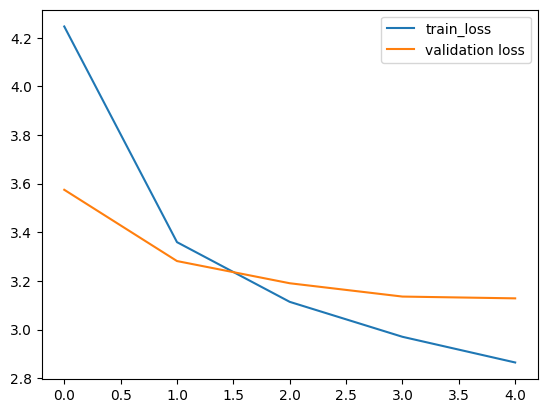

In [38]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()


In [45]:
def load_image_from_path(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.cast(img, tf.float32)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img


def generate_caption(img_path, add_noise=False):
    img = load_image_from_path(img_path)
    
    if add_noise:
        noise = tf.random.normal(img.shape)*0.1
        img = img + noise
        img = (img - tf.reduce_min(img))/(tf.reduce_max(img) - tf.reduce_min(img))
    
    img = tf.expand_dims(img, axis=0)
    img_embed = caption_model.cnn_model(img)
    img_encoded = caption_model.encoder(img_embed, training=False)

    y_inp = '[start]'
    for i in range(MAX_LENGTH-1):
        tokenized = tokenizer([y_inp])[:, :-1]
        mask = tf.cast(tokenized != 0, tf.int32)
        pred = caption_model.decoder(
            tokenized, img_encoded, training=False, mask=mask)
        
        pred_idx = np.argmax(pred[0, i, :])
        pred_idx = tf.convert_to_tensor(pred_idx)
        pred_word = idx2word(pred_idx).numpy().decode('utf-8')
        if pred_word == '[end]':
            break
        
        y_inp += ' ' + pred_word
    
    y_inp = y_inp.replace('[start] ', '')
    return y_inp

In [46]:
load_image_from_path(captions.iloc[0].image)

<tf.Tensor: shape=(299, 299, 3), dtype=float32, numpy=
array([[[ 0.33333337,  0.00392163, -0.6156863 ],
        [ 0.30980396, -0.00392157, -0.6784314 ],
        [ 0.32549024,  0.00392163, -0.67058825],
        ...,
        [ 0.34901965,  0.05098045, -0.46666664],
        [ 0.3411765 ,  0.04313731, -0.45098037],
        [ 0.3411765 ,  0.04313731, -0.45098037]],

       [[ 0.3411765 , -0.01960784, -0.6627451 ],
        [ 0.33333337,  0.01176476, -0.6784314 ],
        [ 0.30980396, -0.01176471, -0.6784314 ],
        ...,
        [ 0.35686278,  0.05098045, -0.4588235 ],
        [ 0.36470592,  0.05098045, -0.4352941 ],
        [ 0.33333337,  0.02745104, -0.47450978]],

       [[ 0.34901965, -0.01960784, -0.62352943],
        [ 0.3176471 , -0.01176471, -0.654902  ],
        [ 0.30980396, -0.01176471, -0.62352943],
        ...,
        [ 0.35686278,  0.05098045, -0.4823529 ],
        [ 0.34901965,  0.02745104, -0.4588235 ],
        [ 0.34901965,  0.0196079 , -0.45098037]],

       ...,

     

Predicted Caption: a group of people flying a kite in the sky



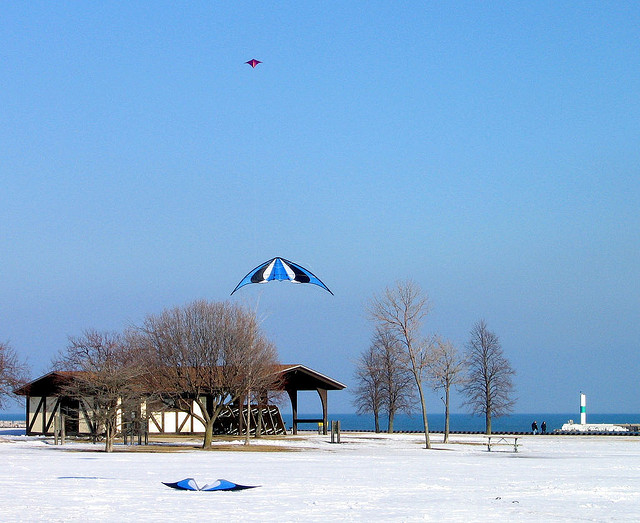

In [92]:
idx = random.randrange(0, len(captions))
img_path = captions.iloc[idx].image

pred_caption = generate_caption(img_path)
print('Predicted Caption:', pred_caption)
print()
Image.open(img_path)

In [95]:
captions

,image,caption
0,F:\COCO\train2014\train2014\COCO_train2014_000...,[start] a small bathroom has a toilet with str...
1,F:\COCO\train2014\train2014\COCO_train2014_000...,[start] a man on a skateboard riding a pipe [end]
2,F:\COCO\train2014\train2014\COCO_train2014_000...,[start] a banana and two lemons sitting on a t...
3,F:\COCO\train2014\train2014\COCO_train2014_000...,[start] this is several zebras in the grass ru...
4,F:\COCO\train2014\train2014\COCO_train2014_000...,[start] a man standing in the middle of a room...
...,...,...
69995,F:\COCO\train2014\train2014\COCO_train2014_000...,[start] a woman brushes her teeth in the livin...
69996,F:\COCO\train2014\train2014\COCO_train2014_000...,[start] a red and white traffic sign affixed t...
69997,F:\COCO\train2014\train2014\COCO_train2014_000...,[start] two people on rrboards are in the ocea...
69998,F:\COCO\train2014\train2014\COCO_train2014_000...,[start] there is building which looks like a p...
